# Импорт модулей

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, LassoLars, Lasso, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

import xgboost as xgb
import lightgbm as lgb

from scipy import stats
from scipy.stats import norm, skew

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt  

import warnings
warnings.filterwarnings('ignore')

!pip install catboost
import catboost

# Работа с данными

In [6]:
data = pd.read_csv("SCI_and_preferences.csv", encoding="utf-8").iloc[:, 1:]

In [7]:
data = data.drop_duplicates(subset=data.columns[2:]).reset_index(drop=True)

In [9]:
data = data.iloc[:, 2:]

In [10]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, train_size=0.8, random_state=0)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

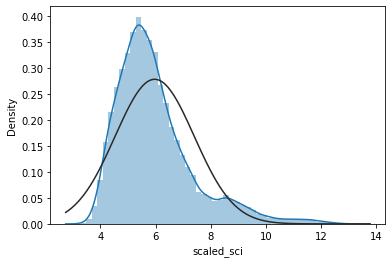

In [13]:
sns.distplot(np.log(y) , fit=norm)
plt.show()

In [14]:
y_train, y_test = np.log(y_train), np.log(y_test)

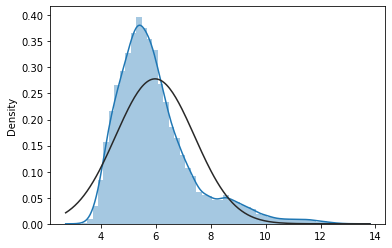

In [15]:
sns.distplot(y_train , fit=norm)
plt.show()

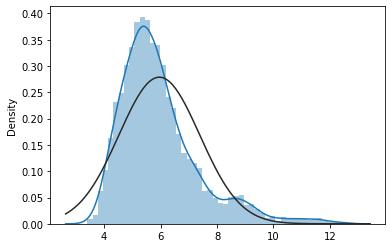

In [16]:
sns.distplot(y_test , fit=norm)
plt.show()

# Построение моделей

In [17]:
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [18]:
boosting_reg = catboost.CatBoostRegressor(eval_metric='RMSE', logging_level='Silent', random_state=0)

In [20]:
boosting_reg.grid_search({'iterations': [500, 1000], 'learning_rate': [0.1, 0.3]}, 
                           X_train, y_train, verbose=False, plot=True, refit=True, cv=5);

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
print('train MAE = {}'.format(mean_absolute_error(y_train, boosting_reg.predict(X_train))))

train MAE = 0.2926529557928739


In [22]:
print('test MAE = {}'.format(mean_absolute_error(y_test, boosting_reg.predict(X_test))))

test MAE = 0.49261560790134074


In [23]:
print('train MAPE = {}%'.format(mape(y_train, boosting_reg.predict(X_train))))

train MAPE = 4.918660022292928%


In [24]:
print('test MAPE = {}%'.format(mape(y_test, boosting_reg.predict(X_test))))

test MAPE = 8.194533704156168%


In [25]:
print('train R_squared = {}'.format(r2_score(y_train, boosting_reg.predict(X_train))))

train R_squared = 0.9250404208626384


In [26]:
print('test R_squared = {}'.format(r2_score(y_test, boosting_reg.predict(X_test))))

test R_squared = 0.7609360401533717


In [32]:
boosting_reg.feature_importances_

array([0.23734151, 0.12490469, 0.15620696, 0.42916325, 0.79508018,
       0.34149538, 0.37717344, 0.4908624 , 0.15265193, 0.48915803,
       2.94714825, 6.84972672, 1.6752135 , 0.25513918, 0.55733527,
       0.46432151, 0.99611397, 0.59823976, 1.76938094, 0.34413344,
       1.35721706, 0.74236487, 0.89963335, 0.90996698, 0.72886555,
       1.08086142, 0.16468474, 0.6413299 , 0.3758199 , 0.16259259,
       0.75040221, 1.39689089, 0.27206486, 3.40790544, 0.36474754,
       0.3140062 , 0.30115744, 2.38994738, 0.68762824, 2.06801865,
       1.59241935, 0.11662826, 0.34413495, 0.44895156, 0.25723723,
       0.32351024, 0.97336855, 0.12561775, 0.27279847, 0.40857706,
       0.36059827, 0.26703842, 0.33112713, 1.94908863, 0.90082971,
       2.71153171, 0.39451287, 1.09134071, 0.36503069, 0.60077197,
       0.29222605, 0.17194676, 0.39369087, 0.24643564, 0.23700741,
       0.19906405, 0.42621641, 1.40727285, 1.06765825, 0.35419566,
       0.28905458, 0.29104604, 0.35059152, 0.10667084, 0.06889

In [27]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
lin_reg.score(X_train, y_train)

0.33367838730878596

In [29]:
lin_reg.score(X_test, y_test)

0.32449934085759624

In [30]:
print('train MAPE = {}%'.format(mape(y_train, lin_reg.predict(X_train))))

train MAPE = 15.009864501664913%


In [31]:
print('test MAPE = {}%'.format(mape(y_test, lin_reg.predict(X_test))))

test MAPE = 15.107749715775013%
